In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, Button
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import seaborn as sns
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from tabulate import tabulate
from collections import Counter


ModuleNotFoundError: No module named 'tabulate'

In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Data Processing 
    
#Read Data
data_raw = pd.read_csv('Concrete_Data.csv')
data_raw = pd.DataFrame(data_raw)

#Correct Missing Values

data = data_raw.copy().dropna()

data

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365.0,43.70
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28.0,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28.0,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28.0,32.77


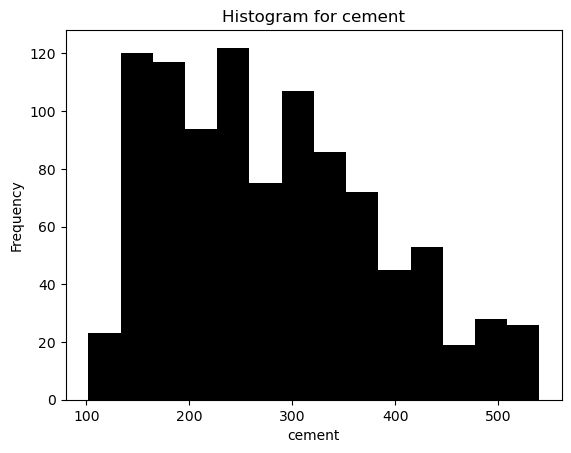

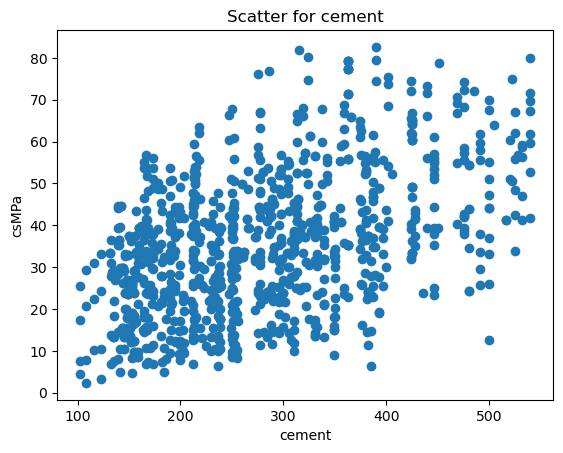

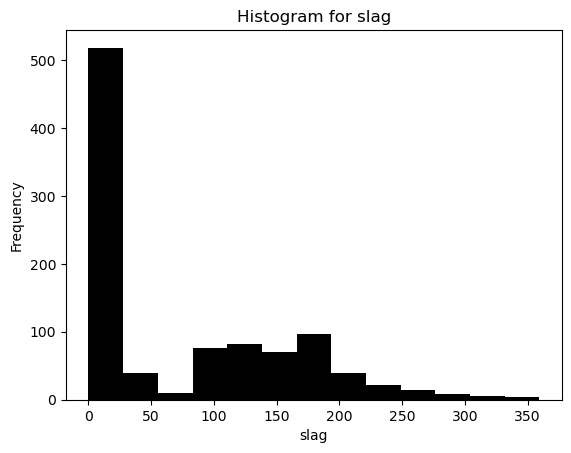

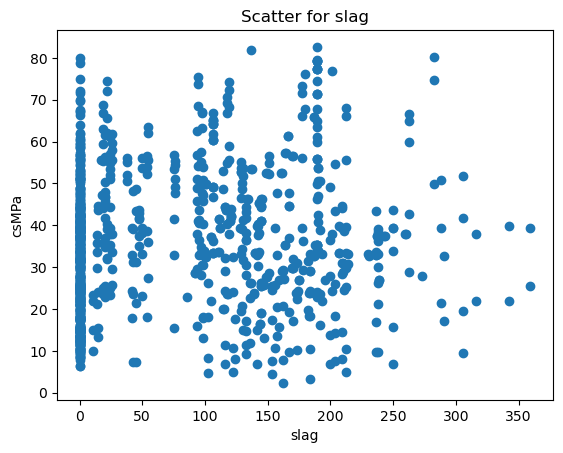

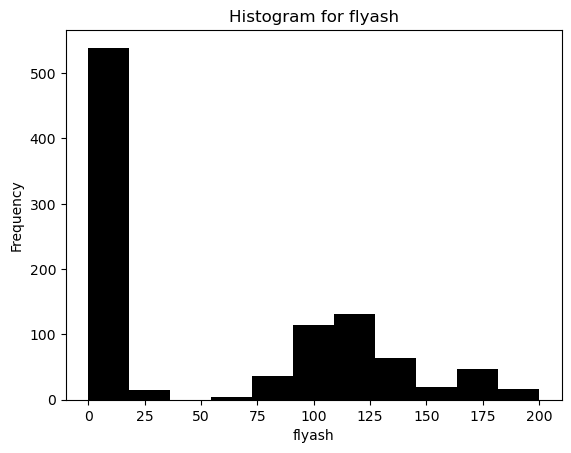

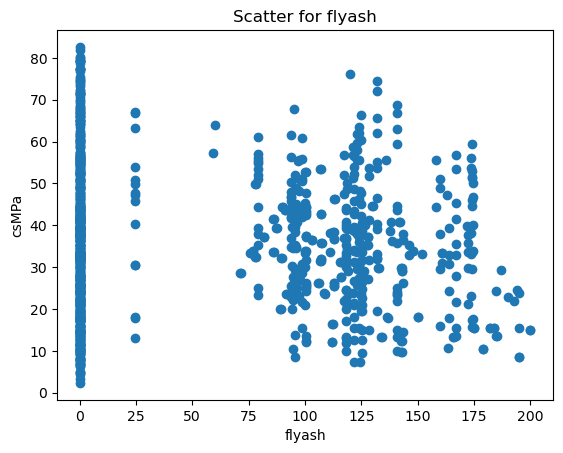

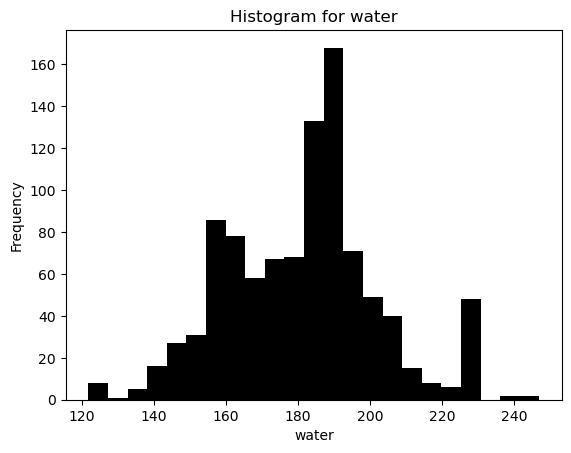

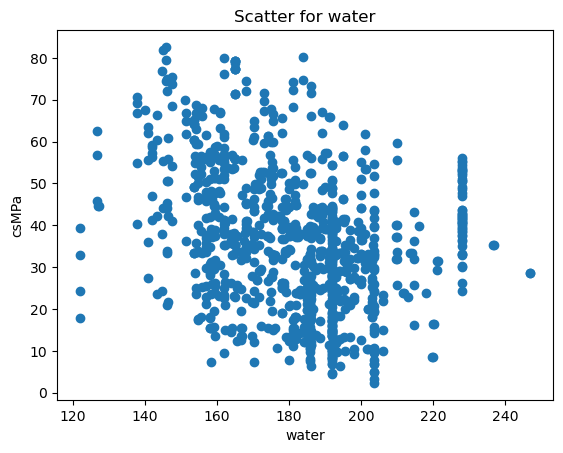

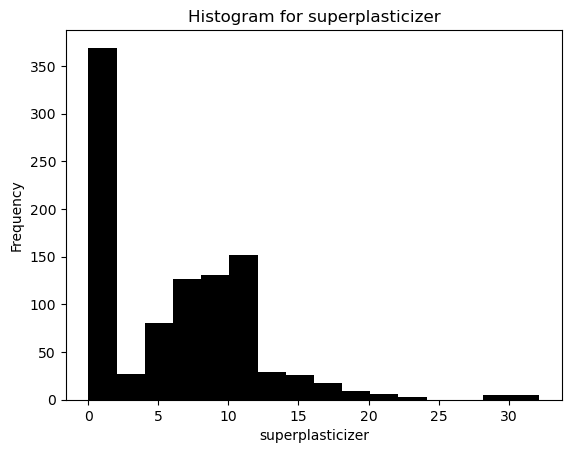

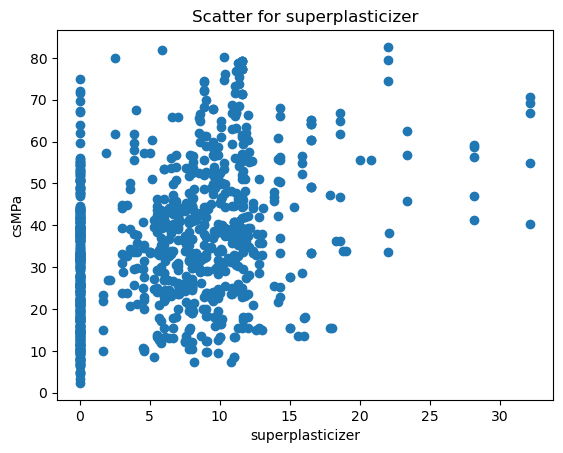

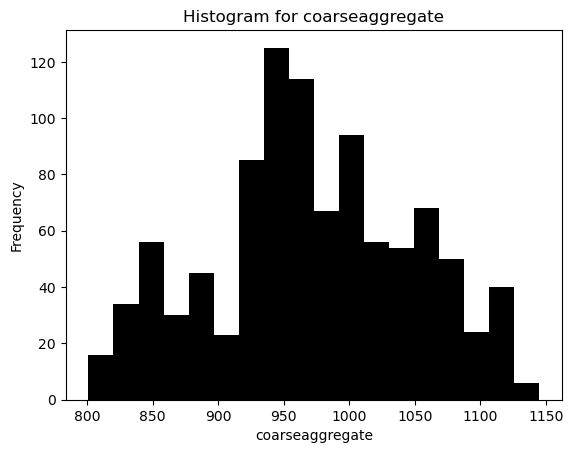

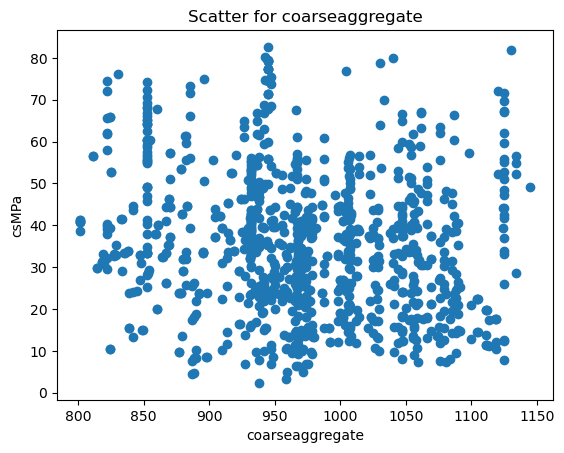

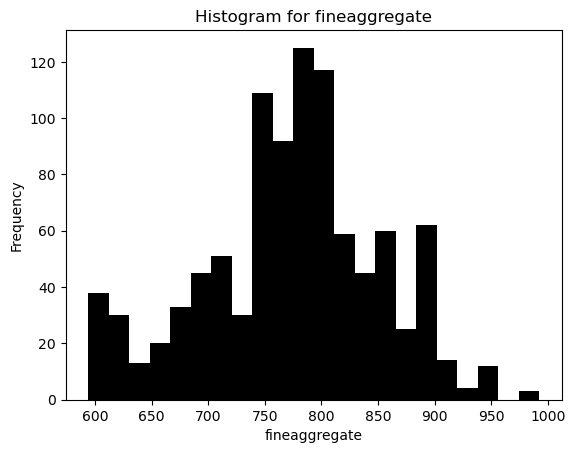

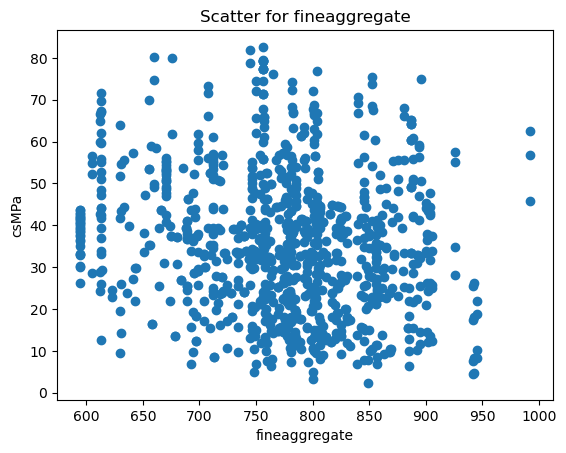

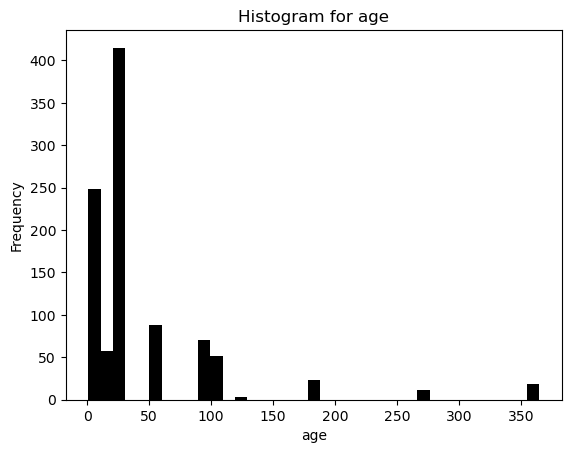

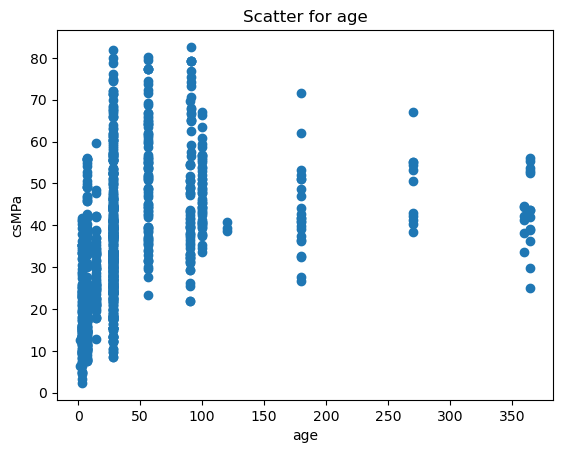

In [3]:
y_column = data.columns[-1]
x_columns = data.columns[:-1]

x = data[x_columns]
y = data[y_column]

# Visualize Data
for column in x_columns:
    # Histograms
    plt.hist(x[column], bins='auto', color='black')
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

    # Scatter Plots
    plt.scatter(x[column], y)
    plt.title(f'Scatter for {column}')
    plt.xlabel(column)
    plt.ylabel(y_column)
    plt.show()


In [4]:
#Scale Data
scaler = preprocessing.StandardScaler()

x_scaled = x.copy()  

for i in x_columns:
    column_data = x[i].values.reshape(-1, 1) 
    scaled_column = scaler.fit_transform(column_data)
    x_scaled[i] = scaled_column.flatten()




All Results:
╒════╤═════════╤══════════════════╤════════════╤══════════╕
│    │ Model   │ Hyperparameter   │      Score │     RMSE │
╞════╪═════════╪══════════════════╪════════════╪══════════╡
│  0 │ RF      │ 20               │  0.85718   │  6.29785 │
├────┼─────────┼──────────────────┼────────────┼──────────┤
│  1 │ RF      │ 20               │  0.877534  │  5.75208 │
├────┼─────────┼──────────────────┼────────────┼──────────┤
│  2 │ RF      │ 50               │  0.876773  │  5.84994 │
├────┼─────────┼──────────────────┼────────────┼──────────┤
│  3 │ RF      │ 50               │  0.88935   │  5.46754 │
├────┼─────────┼──────────────────┼────────────┼──────────┤
│  4 │ RF      │ 80               │  0.867387  │  6.06864 │
├────┼─────────┼──────────────────┼────────────┼──────────┤
│  5 │ RF      │ 80               │  0.888285  │  5.49378 │
├────┼─────────┼──────────────────┼────────────┼──────────┤
│  6 │ RF      │ 110              │  0.874822  │  5.89606 │
├────┼─────────┼──────────

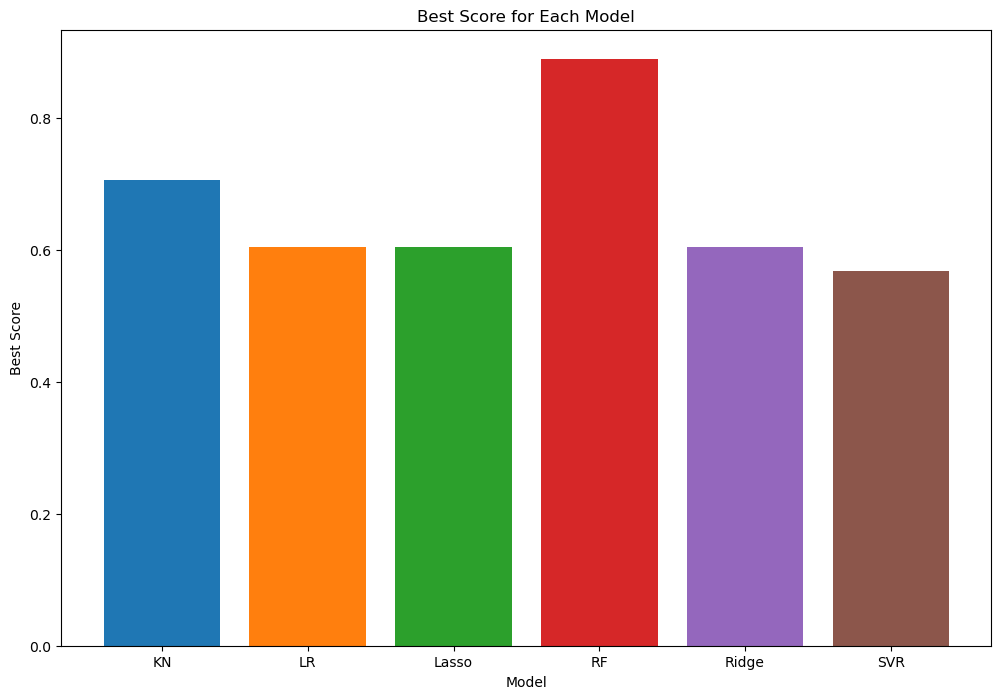

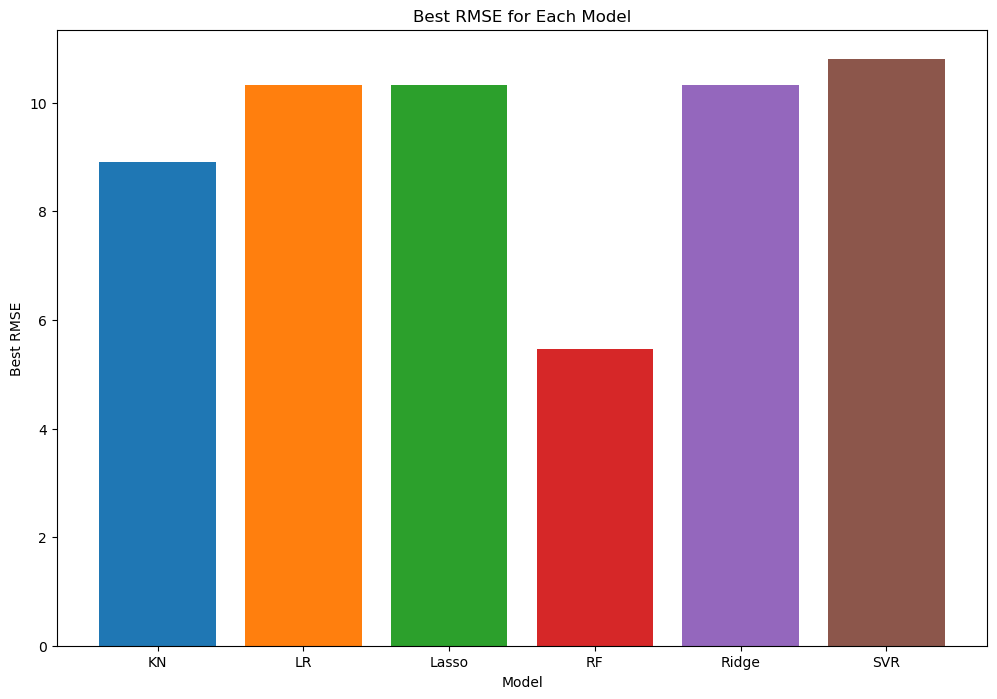

In [5]:
# Define models
models = {
    'RF': RandomForestRegressor(),
    'KN': KNeighborsRegressor(),
    'SVR': SVR(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LR': LinearRegression()
}

# Mapping of models to hyperparameter names and values
model_hyperparams = {
    'RF': {'param_name': 'n_estimators', 'param_values': list(range(20, 141, 30))},
    'KN': {'param_name': 'n_neighbors', 'param_values': list(range(1, 10, 2))},
    'SVR': {'param_name': 'gamma', 'param_values': list(np.logspace(-2, 1, num=min(4, 100), endpoint=True, base=10.0))},
    'Ridge': {'param_name': 'alpha', 'param_values': list(np.logspace(-2, 1, num=min(4, 100), endpoint=True, base=10.0))},
    'Lasso': {'param_name': 'alpha', 'param_values': list(np.logspace(-2, 1, num=min(4, 100), endpoint=True, base=10.0))},
    'LR': {'param_name': 'NA', 'param_values': ['NA']}
}

# List to store cross-validation scores and RMSE
all_results = []

# Set Number of Trials and Number of Splits in KFold
trials = 1
n_splits = 2

# Separate Testing and Training Fractions (simple k-fold should work due to a large dataset/TimeSeriesSplit)
# Note random state is 27
kf = KFold(n_splits=n_splits, shuffle=True, random_state=27)

# Perform Kfold cross-validation

# Iterate the Number of Trials
for i in range(trials):
    
    # Reset scores list for each trial
    scores = []

    # Iterate for Every Model on the List
    for model_name, model_instance in models.items():
        hyper_params_info = model_hyperparams[model_name]
        hyper_params = hyper_params_info['param_values']
        param_name = hyper_params_info['param_name']

        # Iterate for Set List of Hyperparameters
        for param in hyper_params:
            # Instantiate the model with the current hyperparameter
            model_instance = models[model_name]
            if param_name != 'NA':
                model_instance.set_params(**{param_name: param})

            # Perform k-fold cross-validation
            for train_index, val_index in kf.split(x_scaled):
                x_train, x_val = x_scaled.iloc[train_index], x_scaled.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                # Fit the model on the training data
                model_instance.fit(x_train, y_train)

                # Evaluate the model on the validation data and store the score and RMSE
                score = model_instance.score(x_val, y_val)
                y_pred = model_instance.predict(x_val)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                scores.append({'Model': model_name, 'Hyperparameter': param, 'Score': score, 'RMSE': rmse})

    # Store the results for each model in each trial
    all_results.extend(scores)

# Display all results
All_Results = pd.DataFrame(all_results)
print("\nAll Results:")
print(tabulate(All_Results, headers='keys', tablefmt='fancy_grid'))

# ... (previous code)

# Find the index of the rows with the best scores for each model
best_score_indices = All_Results.groupby('Model')['Score'].idxmax()
best_rmse_indices = All_Results.groupby('Model')['RMSE'].idxmin()

# Extract the corresponding rows
best_scores_df = All_Results.loc[best_score_indices]
best_rmse_df = All_Results.loc[best_rmse_indices]

# Set a color palette (you can choose your own or use one of Matplotlib's built-in colormaps)
colors = plt.cm.tab10.colors

# Plot the bar chart for the best scores
plt.figure(figsize=(12, 8))
plt.bar(best_scores_df['Model'], best_scores_df['Score'], color=colors)
plt.xlabel('Model')
plt.ylabel('Best Score')
plt.title('Best Score for Each Model')
plt.show()

# Plot the bar chart for the best RMSE values
plt.figure(figsize=(12, 8))
plt.bar(best_rmse_df['Model'], best_rmse_df['RMSE'], color=colors)
plt.xlabel('Model')
plt.ylabel('Best RMSE')
plt.title('Best RMSE for Each Model')
plt.show()

<IPython.core.display.Javascript object>


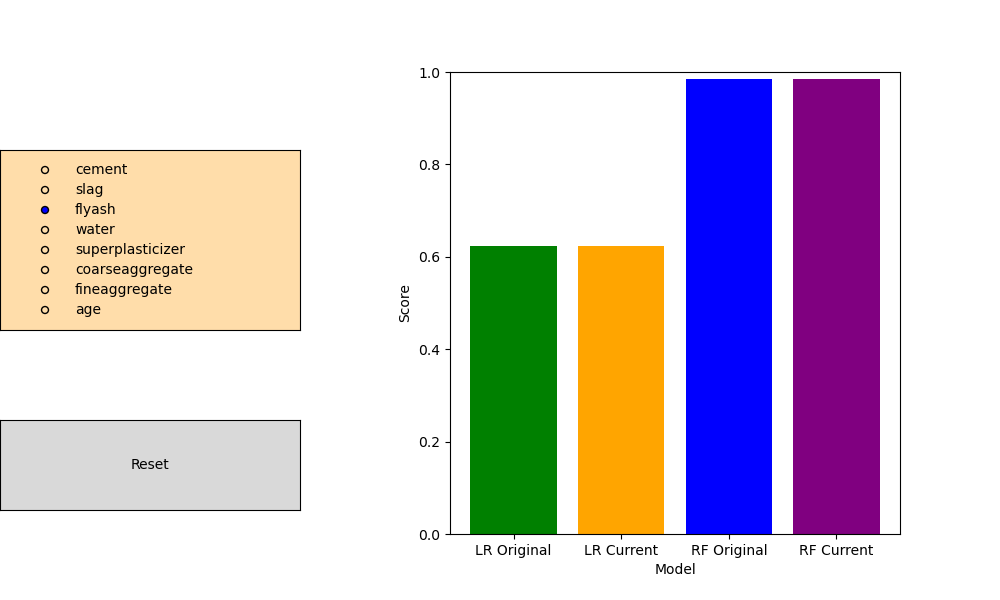

In [12]:
%matplotlib nbagg

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, Button
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def prepare_data(data):
    X = data.drop(data.columns[-1], axis=1)
    y = data[data.columns[-1]]
    return X, y

def fit_and_evaluate_models(X, y):
    rf_model = RandomForestRegressor(n_estimators=50).fit(X, y)
    rf_score = rf_model.score(X, y)
    lr_model = LinearRegression().fit(X, y)
    lr_score = lr_model.score(X, y)
    return rf_score, lr_score

def create_and_update_plot(scores, index, colors, ax):
    ax.clear()
    ax.bar(index, scores, color=colors)
    ax.set_xlabel("Model")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)

fig, ax = plt.subplots(figsize=(10, 6))  # adjust figsize as needed
plt.subplots_adjust(left=0.45)

# Create space for radio buttons and reset button on the side
radio_ax = plt.axes([0.0, 0.45, 0.3, 0.3], facecolor='#FFDDAA')
reset_ax = plt.axes([0.0, 0.15, 0.3, 0.15])

# Create radio buttons with vertical orientation
radio = RadioButtons(radio_ax, features)

# Create reset button
reset_button = Button(reset_ax, "Reset")

original_data = data.copy()  # Store a copy of the original dataset
features = list(data.columns[:-1])

X, y = prepare_data(original_data)
rf_original_score, lr_original_score = fit_and_evaluate_models(X, y)

scores = [lr_original_score, lr_original_score, rf_original_score, rf_original_score]
index = ["LR Original", "LR Current", "RF Original", "RF Current"]
colors = ["green", "orange", "blue", "purple"]

create_and_update_plot(scores, index, colors, ax)

def reset_callback(event):
    global data
    data = original_data.copy()
    X, y = prepare_data(data)
    rf_score, lr_score = fit_and_evaluate_models(X, y)
    scores = [lr_original_score, lr_score, rf_original_score, rf_score]
    create_and_update_plot(scores, index, colors, ax)

def feature_removal_callback(label):
    del data[label]
    X, y = prepare_data(data)
    rf_score, lr_score = fit_and_evaluate_models(X, y)
    scores = [lr_original_score, lr_score, rf_original_score, rf_score]
    create_and_update_plot(scores, index, colors, ax)

# Connect callbacks to buttons
radio.on_clicked(feature_removal_callback)
reset_button.on_clicked(reset_callback)

plt.show()
